In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Hyperparameters 


In [3]:
NOISE = 2
MEAN_NOISE = 0.0

######################################################
# fix me
# Parameters for CNNs
CNN1_inputchannel = 3
CNN1_outchannel = 4 
CNN1_kernal = 11
CNN1_stride = 1

CNN2_outchannel = 8
CNN2_kernal = 8
CNN2_stride = 1

CNN3_outchannel = 16
CNN3_kernal = 4
CNN3_stride = 1

Pool_kernal = 2 # max pooling
Pool_stride = 2

num_epochs = 30
batch_size = 15

sensor_ref = [0,0]
sensor1 = [10,0]
sensor2 = [0,10]
sensor3 = [10,10]

world_size_x = 10
world_size_y = 10
grid_size = 0.1

epsilon = 0.05
temperature = 0.1
######################################################

MC_N = 10** 4  # Number of total simulation
MC_N = int(MC_N * 2)
size_x = 10   # X axis size
size_y = 10   # Y axis size

In [4]:
def target_moving(x_cor_list, y_cor_list, velocity_list, acceleration_list): #측정 시간 단위는 1초로! 속도 단위는 m/s
    x_cor_t_n_1 = x_cor_list[-1]
    y_cor_t_n_1 = y_cor_list[-1]
    velocity = velocity_list[-1]
    acceleration = acceleration_list[-1]
    
    s = velocity * 1        
    direction = 360 * np.random.rand(1)
    
    x_cor_t_n = x_cor_t_n_1 + s * math.cos(direction)
    y_cor_t_n = y_cor_t_n_1 + s * math.sin(direction)
    
    if(x_cor_t_n > world_size_x or x_cor_t_n < 0):
        x_cor_t_n = x_cor_t_n - 2 * s * math.cos(direction)
        
    if(y_cor_t_n > world_size_y or y_cor_t_n < 0):
        y_cor_t_n = y_cor_t_n - 2 * s * math.sin(direction)
        
    
    x_cor_list.append(round(x_cor_t_n,2))
    y_cor_list.append(round(y_cor_t_n,2))   
    
    acceleration = 0.5 * float(np.random.randn(1))
    velocity = velocity + acceleration * 1
    
    if(velocity < 0):
        velocity = 0
        
    elif(velocity>5): #인간 평균 걸음 속도는 1.1m/s 이고 뛰는 평균 속도는 5m/s이다
        velocity = 1.1
    
    acceleration_list.append(round(acceleration,2))
    velocity_list.append(round(velocity,2))
    
# 타겟 X(대문자 X) , x좌표 x(소문자 x)    
X_x_list = [world_size_x / 2]    # 타겟의 첫 x좌표
X_y_list = [world_size_y / 2]    # 타겟의 첫 y좌표 
velocity_list = [1.1]
acceleration_list =[0]   


while(len(X_x_list) < MC_N):
    target_moving(X_x_list, X_y_list, velocity_list, acceleration_list)


sensor_ref_x_list = [0] * MC_N                      #sensor ref x coordinate
sensor_ref_y_list = [0] * MC_N                      #sensor ref  y coordinate
sensor_one_x_list = [size_x] * MC_N                 #sensor 1 x coordinate
sensor_one_y_list = [0] * MC_N                      #sensor 1 y coordinate
sensor_two_x_list = [0] * MC_N                      #sensor 2 x coordinate
sensor_two_y_list = [size_y] * MC_N                 #sensor 2 y coordinate
sensor_three_x_list = [size_x] * MC_N                #sensor 3 x coordinate
sensor_three_y_list = [size_y] * MC_N                #sensor 3 y coordinate

df = pd.DataFrame(data = {'X_x':X_x_list , 'X_y' : X_y_list  
                         })

c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

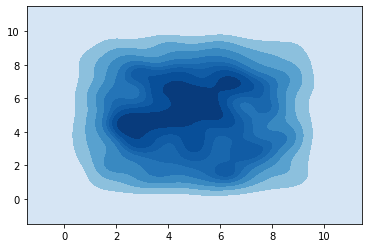

In [5]:
sns.kdeplot(X_x_list , X_y_list, cmap = "Blues" , shade= True, shade_lowest=True)

c:\Users\user\.conda\envs\position31\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


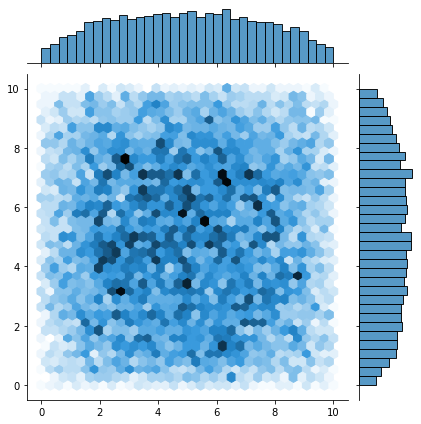

In [6]:
sns.jointplot(X_x_list, X_y_list, kind="hex")

### Example of a TDOA dataset created through an actual experiment.

<img src='https://drive.google.com/uc?id=1Wym8DdqfQuY4VSDFmxiogRXUl_ade25X' width="600">

### Create distance between each sensor and hat data

In [7]:
from __future__ import division, print_function
from multilateration_tdoa import TDoAEngine, TDoAMeasurement, Anchor, Point
import numpy as np

def noise():
    """Returns gaussian noise"""
    return np.random.normal(MEAN_NOISE, NOISE)

def tdoa(A,B,P):
    """Computes |PB| - |PA| + gaussian noise"""
    return P.dist(B)-P.dist(A) + noise()

def fakeTDOA(A,B,P):
    """Returns a fake measurements with anchors A, B from a point P"""
    return TDoAMeasurement(A, B, tdoa(A,B,P))

engine = TDoAEngine(n_measurements=6, max_dist_hess=100) # Avoid value rejection.

A = Anchor((0,0,0))
B = Anchor((world_size_x,0,0))
C = Anchor((world_size_x,world_size_y,0))
D = Anchor((0,world_size_y,0))

TDOA_X_hat_ref_one_error_list = [-100] * MC_N  
TDOA_X_hat_ref_two_error_list = [-100] * MC_N  
TDOA_X_hat_ref_three_error_list = [-100] * MC_N  
 

for i in range(MC_N):
    P = Point(X_x_list[i],X_y_list[i],0)
    
    TDOA_X_hat_ref_one_error_list[i] =   float(fakeTDOA(A, B, P).tdoa) # ref과 앵커 B와 TDOA
    TDOA_X_hat_ref_two_error_list[i] =  float(fakeTDOA(A, C, P).tdoa) # ref과 앵커 C와 TDOA
    TDOA_X_hat_ref_three_error_list[i] =   float(fakeTDOA(A, D, P).tdoa)# ref과 앵커 D와 TDOA

df['TDOA_X_hat_ref_one_error'] = TDOA_X_hat_ref_one_error_list
df['TDOA_X_hat_ref_two_error'] = TDOA_X_hat_ref_two_error_list
df['TDOA_X_hat_ref_three_error'] = TDOA_X_hat_ref_three_error_list

df_parsing = df[['TDOA_X_hat_ref_one_error' , 'TDOA_X_hat_ref_two_error' , 'TDOA_X_hat_ref_three_error' , 'X_x' , 'X_y']]
df_parsing.columns = ['TDOA_1', 'TDOA_2', 'TDOA_3' , 'coordinate_x' , 'coordinate_y']

df_parsing = df_parsing.reset_index(drop=True)

TDOA_X_ref_one_list = df_parsing['TDOA_1'].tolist()
TDOA_X_ref_two_list = df_parsing['TDOA_2'].tolist()
TDOA_X_ref_three_list = df_parsing['TDOA_3'].tolist()

TDOA_pair_ref = [(TDOA_X_ref_one_list[ii], TDOA_X_ref_two_list[ii], TDOA_X_ref_three_list[ii]) for ii in range(len(TDOA_X_ref_one_list))]

ylabel_ref = [(X_x_list[ii] / size_x, X_y_list[ii] / size_y ) for ii in range(len(X_x_list))] 

### Scaling for data 

In [8]:
def ScalerCoordinate(value):   #world size = area's width and height , value =  x,y coordinate
    world_size = 10
    value = value / world_size
    return value


def ScalerTDOA(value):   #world size = area's width and height , value = TDOA value
    #world_size = 25 * 2**(0.5)
    world_size = 100  
    value = value / world_size
    return value


df = df_parsing

df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']] = df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].apply(ScalerTDOA)  #길이에 대하여 스케일링
df[['coordinate_x' , 'coordinate_y']] = df[['coordinate_x' , 'coordinate_y']].apply(ScalerCoordinate)  #좌표에 대하여 스케일링

train_df , test_df = train_test_split(df, test_size = 0.2)

train_TDOAs = train_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
train_X_Hats = train_df[['coordinate_x' , 'coordinate_y']].to_numpy()

test_TDOAs = test_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
test_X_Hats = test_df[['coordinate_x' , 'coordinate_y']].to_numpy()

In [9]:
# TDOA image 생성 모듈 정의
# input: TDPA
# output: TDOA_images
def TDOA_image_generation(sensor1, sensor2, TDOA, world_size_x, world_size_y, grid_size, epsilon, temperature):
   
  center_x = np.linspace(0 , world_size_x , int(world_size_x / grid_size))  + 0.5*grid_size  # x길이 10에 그리드사이즈가 2로 가정했을때 해당 좌표의 중심 좌표는 1, 3, 5, 7, 9 => 이를 수학적으로 수열화 한거!
  center_y = np.linspace(world_size_y , 0 , int(world_size_x / grid_size))  + 0.5*grid_size  # 마찬가지
  cord_center_x, cord_center_y = np.meshgrid(center_x,center_y)  #이를 매트릭스화
  
  distance_matrix = np.sqrt((cord_center_x - sensor1[0])**2 + (cord_center_y - sensor1[1])**2) - np.sqrt((cord_center_x - sensor2[0])**2 + (cord_center_y - sensor2[1])**2)  # 그리드 사이즈 중심좌표로부터 센서간의 거리의 계산 차 (=중심 좌표의 TDOA)
  tdoa_distance = np.abs(distance_matrix - TDOA)  #실제 TDOA 값과 차이 계산

  # 예시 [[10.8,0.38]
  #        [7.679,12.6479]]

  lfunc = lambda x: np.round(1 / (1 + np.exp( (x - epsilon) / temperature)), 5)
  tdoa_image = lfunc(tdoa_distance)

  return tdoa_image

  #### Image size

- Since Grid_size is 0.25, image size is 100,100

In [10]:
TDOA_sample = TDOA_pair_ref[0][0]
TDOA_sample_image = TDOA_image_generation(sensor_ref, sensor1, TDOA_sample, world_size_x, world_size_y, grid_size, epsilon, temperature)
TDOA_sample_image.shape

(100, 100)

In [11]:
TDOA_images_ref = []
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, temperature)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, temperature)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, temperature)
    TDOA_images_ref.append((image1, image2, image3))
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


### Split train and test set

In [12]:
TDOA_images_cnn = TDOA_images_ref
ylabels = ylabel_ref

TDOA_images_test = TDOA_images_cnn[int(0.8*MC_N):]
TDOA_image_val = TDOA_images_cnn[int(0.6*MC_N):int(0.8*MC_N)]
TDOA_image_train = TDOA_images_cnn[:int(0.6*MC_N)]

ylabels_test = ylabels[int(0.8*MC_N):]
ylabels_val = ylabels[int(0.6*MC_N):int(0.8*MC_N)]
ylabels_train = ylabels[:int(0.6*MC_N)]

### Make model structure



In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_cnn():
    model = keras.Sequential()

    model.add(layers.Conv2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN1_stride, 
                            input_shape= (TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel) ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides= (Pool_stride, Pool_stride), padding = "SAME"  ) )
    model.add(layers.Conv2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),  activation=layers.LeakyReLU(alpha=0.01), strides=CNN2_stride ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
    model.add(layers.Dropout(0.6))
    model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal'))
    model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
    model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal')) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2, activation=None))
    return model

model = create_cnn()

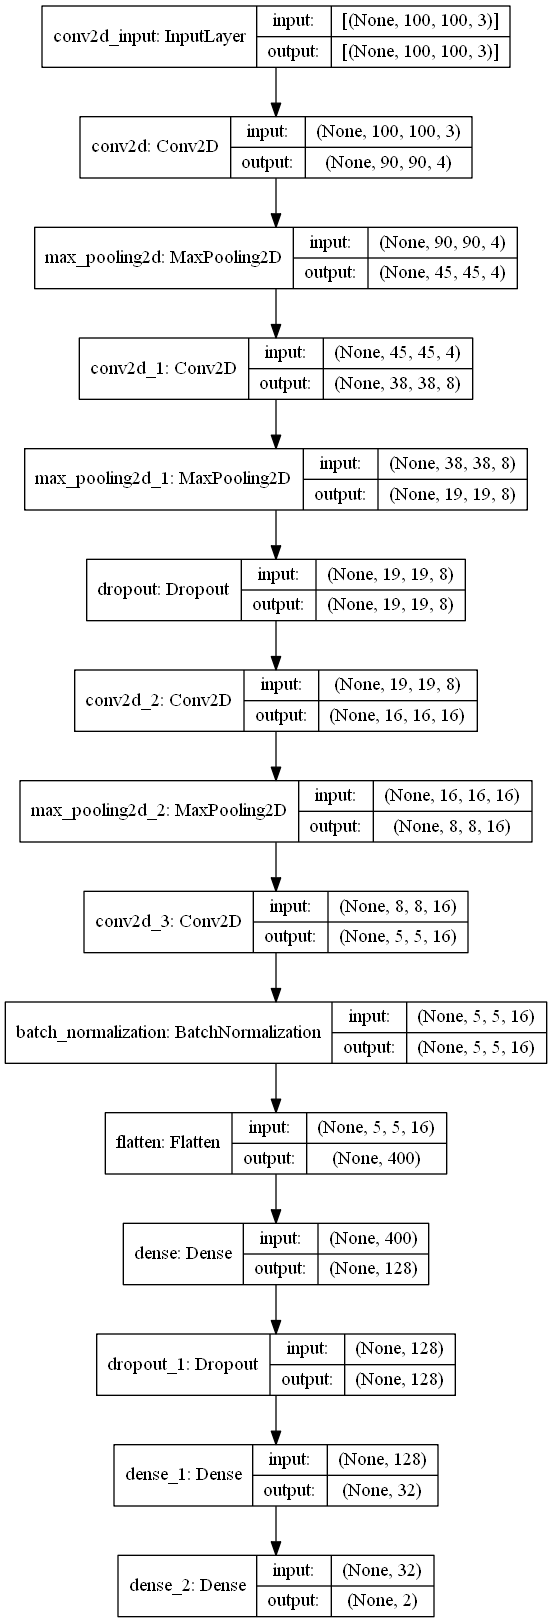

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 4)         1456      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 8)         2056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2064      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0

In [16]:
import os

checkpoint_path = "weight/cnn/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_loss', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.8, verbose=1, mode="min",
                              patience=4, min_lr=0.0001)


model.compile(optimizer=Adam(learning_rate=1 * 1e-4),
        loss='MSE',
        metrics=['mse'])


history = model.fit(np.array(TDOA_image_train).swapaxes(1,3), np.array(ylabels_train),
                    epochs=num_epochs, batch_size=batch_size,verbose=1,
                    validation_data=(np.array(TDOA_image_val).swapaxes(1,3), np.array(ylabels_val)),
                     callbacks= [ earlystopping, reduce_lr, cp_callback])

print('Finished Training')

Epoch 1/30
800/800 [==============================] - 10s 9ms/step - loss: 0.6789 - mse: 0.6789 - val_loss: 0.0725 - val_mse: 0.0725

Epoch 00001: saving model to weight/cnn\cp-01.ckpt
Epoch 2/30
800/800 [==============================] - 6s 8ms/step - loss: 0.1470 - mse: 0.1470 - val_loss: 0.0671 - val_mse: 0.0671

Epoch 00002: saving model to weight/cnn\cp-02.ckpt
Epoch 3/30
800/800 [==============================] - 6s 8ms/step - loss: 0.0890 - mse: 0.0890 - val_loss: 0.0628 - val_mse: 0.0628

Epoch 00003: saving model to weight/cnn\cp-03.ckpt
Epoch 4/30
800/800 [==============================] - 6s 8ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0575 - val_mse: 0.0575

Epoch 00004: saving model to weight/cnn\cp-04.ckpt
Epoch 5/30
800/800 [==============================] - 6s 8ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0522 - val_mse: 0.0522

Epoch 00005: saving model to weight/cnn\cp-05.ckpt
Epoch 6/30
800/800 [==============================] - 6s 8ms/step - loss: 0.048

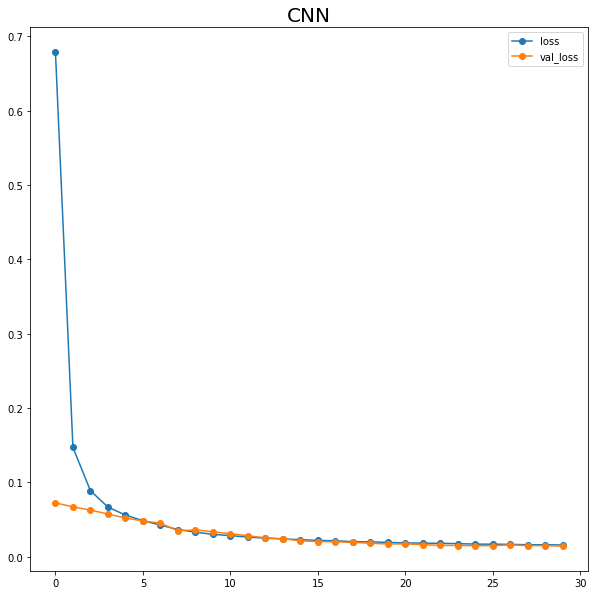

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('CNN', fontsize=20)
plt.show()

In [18]:
val_loss_history = hist.history["val_loss"]
max_point = val_loss_history.index(min(val_loss_history))

model = create_cnn()
model.compile(optimizer=Adam(learning_rate=1 * 1e-3),
        loss='MSE',
        metrics=['mse'])

if max_point > 9:
    model.load_weights(
        "weight/cnn/cp-" + str(max_point+1) + ".ckpt"
    )
else:
    model.load_weights(
        "weight/cnn/cp-0" + str(max_point+1) + ".ckpt"
    )

In [19]:
predict_X_Hats = model.predict(np.array(TDOA_images_test).swapaxes(1,3))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - np.array(ylabels_test)*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.4789 미터


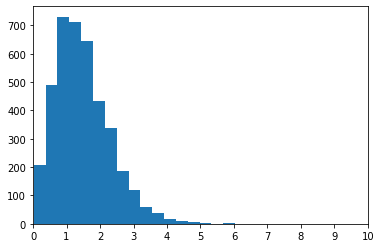

In [20]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()


  <img src='https://drive.google.com/uc?id=1TRRt2YHofQiDwstmSEIkLiWsmK2EKut5' width="350">

# Results

### 1. Grid size really matters. 

The smaller the grid size, the more data for model input become more complex but the result is better. (Tradeoff between computational time and error)

< For grid_size = 1>

<img src='https://drive.google.com/uc?id=1TOz4y_V3nlOJZOyQVXCMRR7hfQhtSV-J' width="350">

< For grid_size = 0.5>

<img src='https://drive.google.com/uc?id=1TPEyYMEnw373MX247bg8uNxfVx038zNt' width="300">


### 2. Probability_gap and Epsilon must change relation to Grid size 

If the value grid size changes, the hyperparameters must be modified accordingly.In the process, the following facts were additionally discovered.



*   The probability gap is not unconditionally good because it is large unlike the grid size.
*   Most of the epsilon values showed good performance when values slightly smaller than (gridsize / probability_gap * 2).



### 3. Comparing with reference paper [Nitsoo et al., 2018]

<img src='https://drive.google.com/uc?id=1TPrf8VJXT4FzvFmAspuF8G5nIhLNfFix' width="600">


  <img src='https://drive.google.com/uc?id=1TQu6JWMw4gs6nN97aX13zp1oFusLRFN_' width="600">

  In our reference paper, coverage area is 13m x 20m, 
  \
   MAE is 0.3m~0.8m by various algorithms.

  Our coverage area is 25m x 25m and MAE for CNN model is 0.4m
  \
  If we consider large coverage area compare and error rate, our result is quite **meaningful** even considering that the environment is a little different.




## 3. FCNN (Fully connected Neural Network) Result

In [21]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

def create_fcnn():
    model2 = models.Sequential()
    model2.add(layers.Dense(32, activation='relu', input_shape=(3,)))
    model2.add(layers.Dropout(0.4))
    model2.add(layers.Dense(16, activation='relu'))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(2))
    model2.compile(optimizer=Adam(learning_rate=1 * 1e-3), loss='mse', metrics=['mse'])
    return model2

checkpoint_path = "weight/fcnn/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_loss', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.8, verbose=1, mode="min",
                              patience=4, min_lr=0.0001)

model2 = create_fcnn()


history = model2.fit(train_TDOAs[:int(0.75*MC_N*0.8)], 
                      train_X_Hats[:int(0.75*MC_N*0.8)],
                      epochs=num_epochs,
                      batch_size=batch_size,
                      callbacks= [earlystopping, reduce_lr,cp_callback],
                      validation_data = (train_TDOAs[int(0.75*MC_N*0.8):], train_X_Hats[int(0.75*MC_N*0.8):]),
                      verbose=1)



Epoch 1/30
800/800 [==============================] - 2s 3ms/step - loss: 0.0775 - mse: 0.0775 - val_loss: 0.0119 - val_mse: 0.0119

Epoch 00001: saving model to weight/fcnn\cp-01.ckpt
Epoch 2/30
800/800 [==============================] - 2s 2ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0113 - val_mse: 0.0113

Epoch 00002: saving model to weight/fcnn\cp-02.ckpt
Epoch 3/30
800/800 [==============================] - 2s 2ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0110 - val_mse: 0.0110

Epoch 00003: saving model to weight/fcnn\cp-03.ckpt
Epoch 4/30
800/800 [==============================] - 2s 2ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0112 - val_mse: 0.0112

Epoch 00004: saving model to weight/fcnn\cp-04.ckpt
Epoch 5/30
800/800 [==============================] - 2s 2ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0112 - val_mse: 0.0112

Epoch 00005: saving model to weight/fcnn\cp-05.ckpt
Epoch 6/30
800/800 [==============================] - 2s 2ms/step - loss: 0

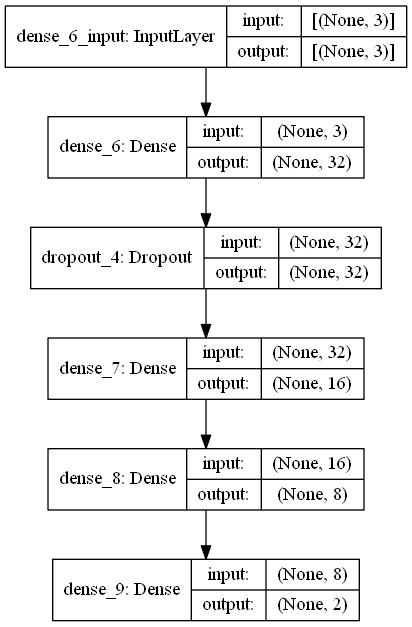

In [22]:
plot_model(model2, show_shapes=True, show_layer_names=True)

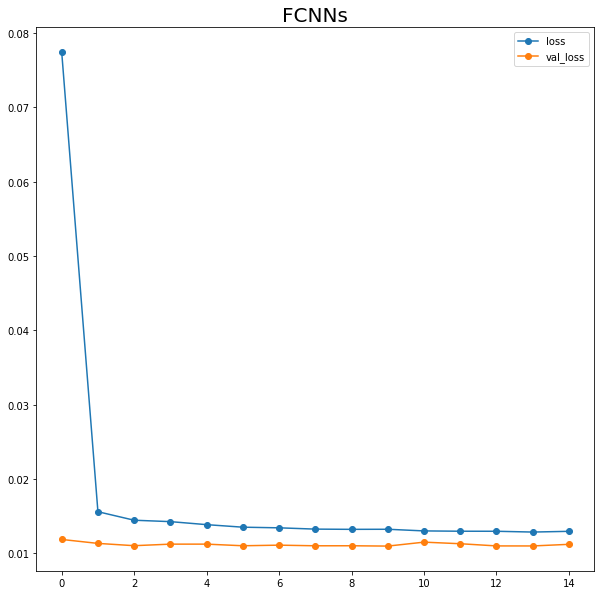

In [23]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('FCNNs', fontsize=20)
plt.show()

In [24]:
val_loss_history = hist.history["val_loss"]
max_point3 = val_loss_history.index(min(val_loss_history))

model2 = create_fcnn()

if max_point3 > 8:
    model2.load_weights(
        "weight/fcnn/cp-" + str(max_point3+1) + ".ckpt"
    )
else:
    model2.load_weights(
        "weight/fcnn/cp-0" + str(max_point3+1) + ".ckpt"
    )

predict_X_Hats = model2.predict(test_TDOAs)

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - test_X_Hats*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.3215 미터


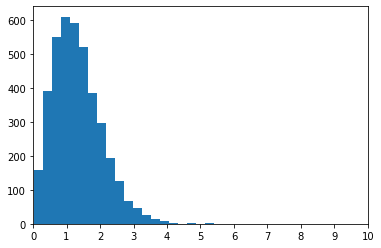

In [25]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

# Simple LSTM

In [26]:
def buildDataSet(X, y, seqLength):
    xdata = []
    ydata = [] 
    for i in range(0, len(X)-seqLength):
        tx = X[i:i+seqLength,:]
        ty = y[i+seqLength,[-1]]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

seqLength=4
trainX_lstm, trainY_lstm=buildDataSet(train_TDOAs, train_X_Hats, seqLength)
testX_lstm, testY_lstm=buildDataSet(test_TDOAs, test_X_Hats, seqLength)

In [27]:
from tensorflow.keras.layers import LSTM

def create_lstm():
    model_lstm = models.Sequential()
    model_lstm.add(LSTM(16,input_shape=(seqLength, 3),return_sequences=False)) 
    model_lstm.add(layers.Dropout(0.5))
    model_lstm.add(layers.Dense(4)) 
    model_lstm.add(layers.Dense(2)) 
    model_lstm.compile(optimizer=Adam(learning_rate=1.0 * 1e-3), loss='mse', metrics=['mse'])
    return model_lstm


model_lstm =  create_lstm()

In [28]:
checkpoint_path = "weight/lstm/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_loss', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)
                              
history = model_lstm.fit(trainX_lstm[:int(0.75*MC_N*0.8)], 
                      trainY_lstm[:int(0.75*MC_N*0.8)],
                      epochs=num_epochs,
                      batch_size=batch_size,
                      verbose=1,
                      validation_data= (trainX_lstm[int(0.75*MC_N*0.8):], trainY_lstm[int(0.75*MC_N*0.8):]),
                      callbacks= [earlystopping, reduce_lr,cp_callback] 
                      )
                      
                      

Epoch 1/30
800/800 [==============================] - 4s 3ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0641 - val_mse: 0.0641

Epoch 00001: saving model to weight/lstm\cp-01.ckpt
Epoch 2/30
800/800 [==============================] - 2s 3ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0641 - val_mse: 0.0641

Epoch 00002: saving model to weight/lstm\cp-02.ckpt
Epoch 3/30
800/800 [==============================] - 3s 3ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0641 - val_mse: 0.0641

Epoch 00003: saving model to weight/lstm\cp-03.ckpt
Epoch 4/30
800/800 [==============================] - 2s 3ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0649 - val_mse: 0.0649

Epoch 00004: saving model to weight/lstm\cp-04.ckpt
Epoch 5/30
800/800 [==============================] - 2s 3ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0641 - val_mse: 0.0641

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 00005: saving model to weight/lstm\cp-05.

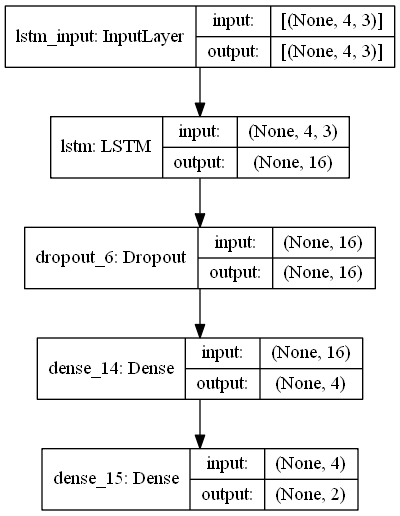

In [29]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

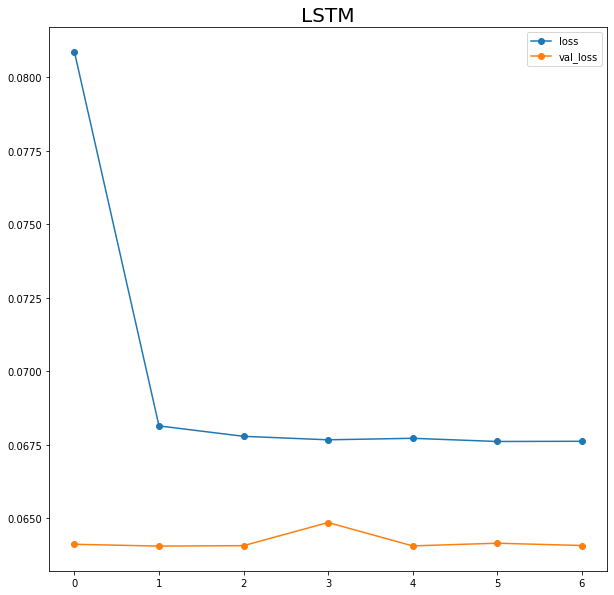

In [30]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('LSTM', fontsize=20)
plt.show()

In [31]:
val_loss_history = hist.history["val_loss"]
max_point4 = val_loss_history.index(min(val_loss_history))

model_lstm = create_lstm()

if max_point4 > 8:
    model_lstm.load_weights(
        "weight/lstm/cp-" + str(max_point4+1) + ".ckpt"
    )
else:
    model_lstm.load_weights(
        "weight/lstm/cp-0" + str(max_point4+1) + ".ckpt"
    )


predict_X_Hats = model_lstm.predict(testX_lstm)

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x - testY_lstm*world_size_x), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  3.0972 미터


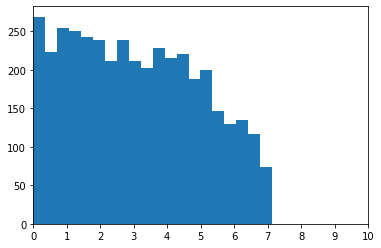

In [32]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

# CNN-LSTM

In [33]:
lstm_time_series = 4

TDOA_images_ref_temp = np.array(TDOA_images_ref)

for i in range(lstm_time_series):
    globals()['TDOA_imgaes_lstm{}'.format(i)] = TDOA_images_ref_temp[i:int(MC_N-lstm_time_series+i+1)]

TDOA_images_lstm = np.stack(  [TDOA_imgaes_lstm0 , TDOA_imgaes_lstm1,TDOA_imgaes_lstm2,TDOA_imgaes_lstm3] ,axis=1 )

In [34]:
ylabels = np.array(ylabels)

for i in range(lstm_time_series):
    globals()['ylabels_lstm{}'.format(i)] = ylabels[i:int(MC_N-lstm_time_series+i+1)]

ylabels_lstm = np.stack(  [ylabels_lstm0, ylabels_lstm1, ylabels_lstm2, ylabels_lstm3] ,axis=1 )

ylabels_lstm = ylabels[lstm_time_series-1:]

In [35]:
TDOA_images_lstm.shape

(19997, 4, 3, 100, 100)

In [36]:
ylabels_lstm.shape

(19997, 2)

In [37]:
TDOA_images_test_lstm = TDOA_images_lstm[int(0.8*MC_N):]
TDOA_image_val_lstm = TDOA_images_lstm[int(0.6*MC_N):int(0.8*MC_N)]
TDOA_image_train_lstm = TDOA_images_lstm[:int(0.6*MC_N)]



ylabels_test_lstm = ylabels_lstm[int(0.8*MC_N):]
ylabels_val_lstm = ylabels_lstm[int(0.6*MC_N):int(0.8*MC_N)]
ylabels_train_lstm = ylabels_lstm[:int(0.6*MC_N)]

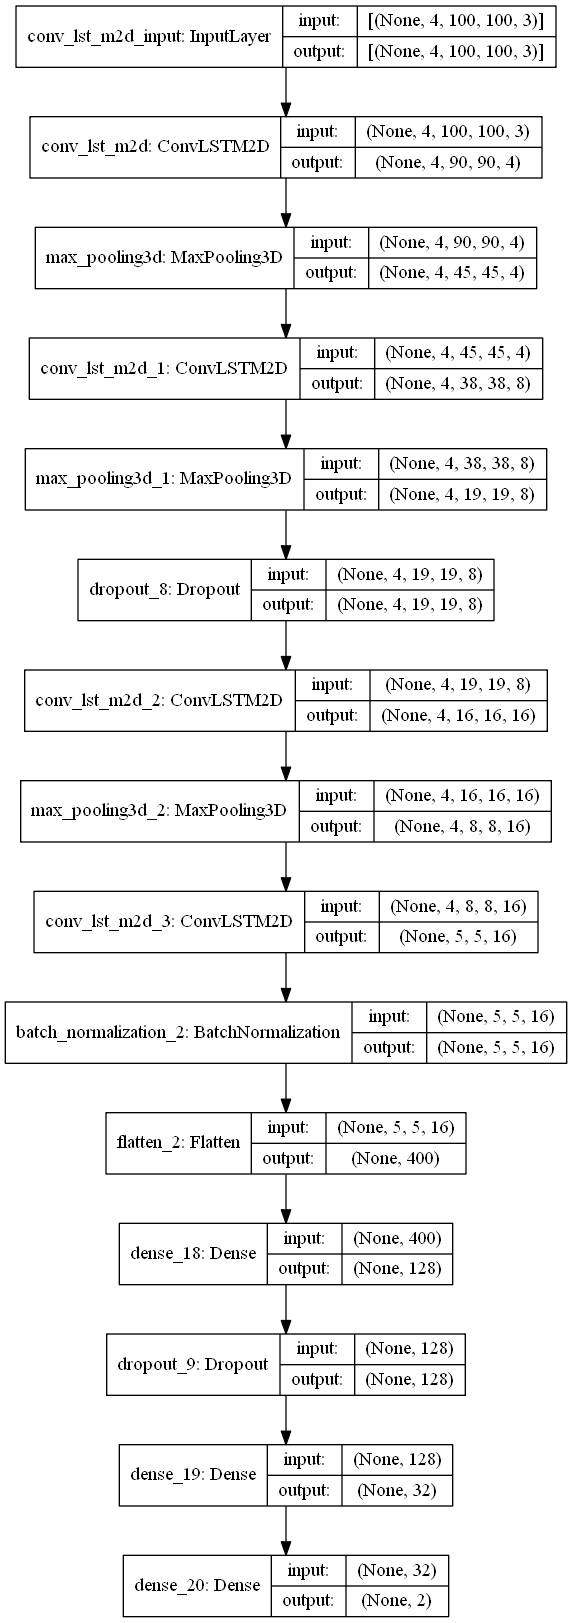

In [38]:
def create_conv_lstm():
    seq = keras.Sequential()
    seq.add(layers.ConvLSTM2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal),
                            input_shape= (4, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1], CNN1_inputchannel ) ,return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides= (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.ConvLSTM2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal),return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.Dropout(0.6))
    seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=True))
    seq.add(layers.MaxPool3D(pool_size=(Pool_kernal,Pool_kernal,Pool_kernal), strides=  (1,Pool_stride, Pool_stride), padding = "SAME"))
    seq.add(layers.ConvLSTM2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal),return_sequences=False))
    seq.add(layers.BatchNormalization()) 
    seq.add(layers.Flatten())
    seq.add(layers.Dense(128, activation='relu'))
    seq.add(layers.Dropout(0.5))
    seq.add(layers.Dense(32, activation='relu'))
    seq.add(layers.Dense(2, activation=None))
    return seq



seq = create_conv_lstm()
plot_model(seq, show_shapes=True, show_layer_names=True)

In [39]:
seq.compile(optimizer=Adam(learning_rate=1.0 * 1e-3),
        loss='mse',
        metrics=['mse'])

checkpoint_path = "weight/conv_cnn/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_mse', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', 
                              patience=8) 


history = seq.fit(TDOA_image_train_lstm.swapaxes(2,4), ylabels_train_lstm,
                    epochs=num_epochs, batch_size=batch_size,verbose=1,validation_data=(TDOA_image_val_lstm.swapaxes(2,4), ylabels_val_lstm),
                     callbacks= [earlystopping, reduce_lr, cp_callback])

print('Finished Training')

Epoch 1/30
800/800 [==============================] - 167s 203ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0162 - val_mse: 0.0162

Epoch 00001: saving model to weight/conv_cnn\cp-01.ckpt
Epoch 2/30
800/800 [==============================] - 150s 188ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0298 - val_mse: 0.0298

Epoch 00002: saving model to weight/conv_cnn\cp-02.ckpt
Epoch 3/30
800/800 [==============================] - 149s 186ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0152 - val_mse: 0.0152

Epoch 00003: saving model to weight/conv_cnn\cp-03.ckpt
Epoch 4/30
800/800 [==============================] - 149s 186ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0122 - val_mse: 0.0122

Epoch 00004: saving model to weight/conv_cnn\cp-04.ckpt
Epoch 5/30
800/800 [==============================] - 151s 189ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0150 - val_mse: 0.0150

Epoch 00005: saving model to weight/conv_cnn\cp-05.ckpt
Epoch 6/30
800/800 [===============

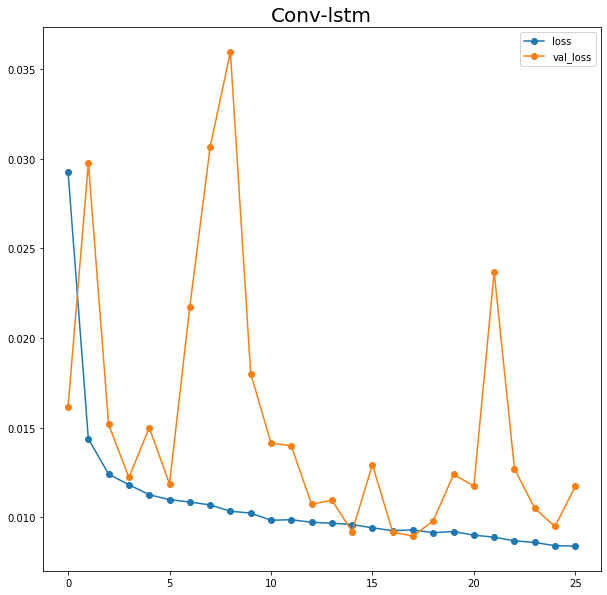

In [40]:
hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('Conv-lstm', fontsize=20)
plt.show()

In [41]:
val_loss_history = hist.history["val_loss"]
max_point2 = val_loss_history.index(min(val_loss_history))

seq = create_conv_lstm()
seq.compile(optimizer=Adam(learning_rate=1 * 1e-3),
        loss='MSE',
        metrics=['mse'])

if max_point2 > 8:
    seq.load_weights(
        "weight/conv_cnn/cp-" + str(max_point2+1) + ".ckpt"
    )
else:
    seq.load_weights(
        "weight/conv_cnn/cp-0" + str(max_point2+1) + ".ckpt"
    )

In [42]:
predict_X_Hats = seq.predict(TDOA_images_test_lstm.swapaxes(2,4))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*world_size_x -ylabels_test_lstm*world_size_x), axis = 1))
mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  1.2082 미터


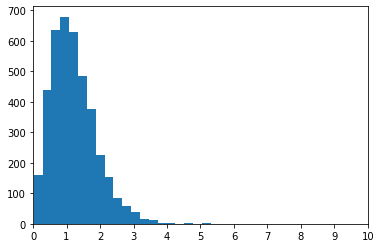

In [43]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

In [44]:
max_point

29

In [45]:
max_point3

9

In [46]:
max_point2

17